# Discrete-time systems under uncertainty

This is a little study to highlight the difficulties with dynamic systems under uncertainty.

Suppose we have the discre-time system for times $t \in \mathbb{N}_0$
$$
x(t+1) = d \, x(t), \quad x(0) = x_0,
$$
where $d$ is not known precisely, and $x_0$ is the (precisely known) initial condition. Specifically, we assume that $d$ follows a continuous uniform distribution on $(-1, 1)$, hence has an expected value of zero, i.e. $\mathrm{E}(d) = 0$.
We readily obtain the solution
$$
x(t) = x_0 d^t.
$$
Taking the expected value of the solution we obtain
$$
\mathrm{E}(x(t)) = x_0 \mathrm{E}(d^t) = \frac{1}{t + 1} \sum_{k=0}^{t} (-1)^k = \begin{cases}
0, &\text{$t$ is odd,} \\
\frac{x_0}{t + 1}, &\text{$t$ is even.}
\end{cases}
$$
We hence see that the expected value takes on a rather odd form.
Let us investigate this numerically.

We begin by defining the system dynamics.

In [1]:
function system_dynamics(x, d)
	x*d
end

system_dynamics (generic function with 1 method)

We specify the numerical input as follows:

In [2]:
N = 10000 # number of samples
d_samples = -1 .+ 2*rand(N) # uniform samples
x0 = 1.0 # initial condition
T = 15 # end time

15

To generate the trajectory of the system for time $t \in \{0, \hdots, T \}$ for a given realization $d$ of the uncertainty we define a helper function.

In [3]:
function create_paths(x0, T, D)
	x_samples = Vector{Float64}[]
	for d in D
		x_path = [x0]
		for t in 1:T
			push!(x_path, system_dynamics(x_path[t], d))
		end
		push!(x_samples, x_path)
	end
	x_samples
end

x_samples = create_paths(x0, T, d_samples)

10000-element Array{Array{Float64,1},1}:
 [1.0, -0.045785, 0.00209627, -9.59778e-5, 4.39435e-6, -2.01195e-7, 9.21173e-9, -4.2176e-10, 1.93103e-11, -8.84122e-13, 4.04795e-14, -1.85336e-15, 8.4856e-17, -3.88514e-18, 1.77881e-19, -8.14429e-21]     
 [1.0, -0.824956, 0.680552, -0.561426, 0.463151, -0.382079, 0.315199, -0.260025, 0.214509, -0.176961, 0.145985, -0.120431, 0.0993502, -0.0819595, 0.067613, -0.0557777]                                     
 [1.0, 0.302057, 0.0912387, 0.0275593, 0.00832449, 0.00251448, 0.000759516, 0.000229417, 6.92972e-5, 2.09317e-5, 6.32259e-6, 1.90978e-6, 5.76864e-7, 1.74246e-7, 5.26323e-8, 1.5898e-8]                     
 [1.0, -0.589807, 0.347873, -0.205178, 0.121015, -0.0713758, 0.042098, -0.0248297, 0.0146447, -0.00863758, 0.00509451, -0.00300478, 0.00177224, -0.00104528, 0.000616515, -0.000363625]                     
 [1.0, -0.55604, 0.309181, -0.171917, 0.0955928, -0.0531534, 0.0295554, -0.016434, 0.00913798, -0.00508108, 0.00282529, -0.00157097, 0.0008

Let's check the numerical mean of the sampled solution

In [4]:
using Statistics
ev_numeric = mean(x_samples)

16-element Array{Float64,1}:
 1.0                  
 0.0007101387665916665
 0.33795156007952043  
 0.0018186779534364067
 0.2018674976606056   
 0.0018247527057299125
 0.14331605028641997  
 0.0016710954219667105
 0.1108924818384903   
 0.0014740995030357792
 0.09037702880590591  
 0.0012784396517110544
 0.07625944349922391  
 0.0011025717202380885
 0.06596284282372844  
 0.00095155360097084  

How does that compare to the analytical solution? *Note how we use multiple dispatch to overload the time argument*

In [5]:
function ev_uncertain_parameter(t::Int, x0)
	t < 0 && throw(DomainError(t, "only non-negative times allowed"))
	iseven(t) ? x0 / (t+1) : 0.
end

function ev_uncertain_parameter(t, x0)
	[ev_uncertain_parameter(τ, x0) for τ in t]
end

ev_analytic = ev_uncertain_parameter(0:T, x0)

16-element Array{Float64,1}:
 1.0                
 0.0                
 0.3333333333333333 
 0.0                
 0.2                
 0.0                
 0.14285714285714285
 0.0                
 0.1111111111111111 
 0.0                
 0.09090909090909091
 0.0                
 0.07692307692307693
 0.0                
 0.06666666666666667
 0.0                

As is often the case, it's useful to plot the solutions to get a visual feel.

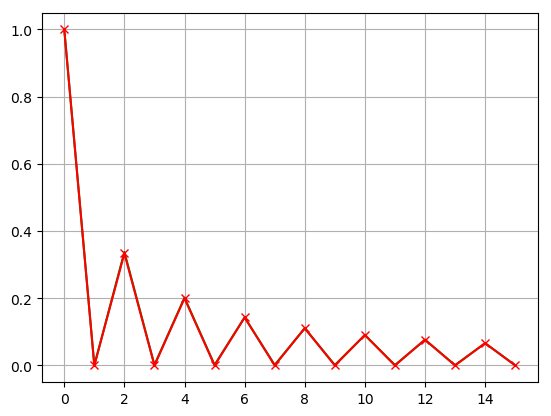

In [6]:
using PyPlot
figure(100)
plot(0:T, ev_numeric, color="green")
plot(0:T, ev_analytic, "-rx")
grid()

Indeed, this gives the expected zig-zag line that is zero whenever the time instant $t$ is odd.

Finally, let us study the distribution of the state over time.
We create a helper function that extracts the $N$ sample points for every time instant $t$.

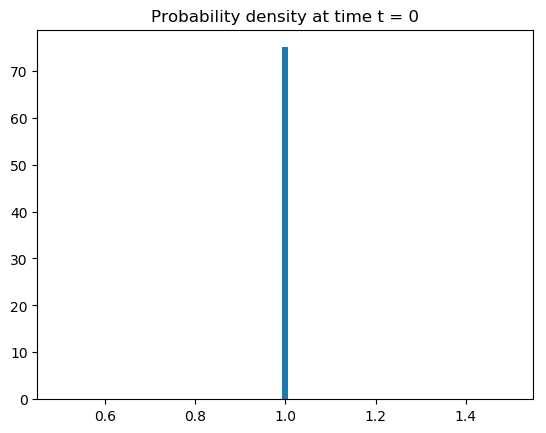

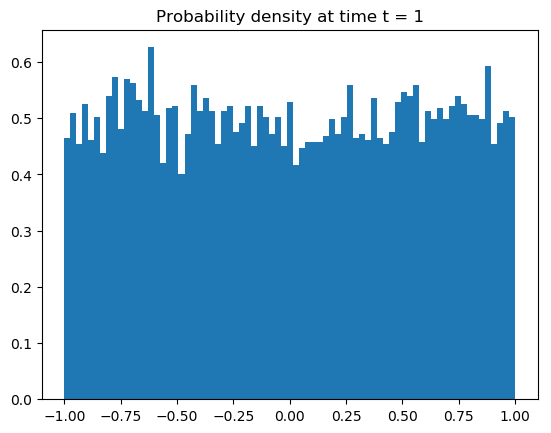

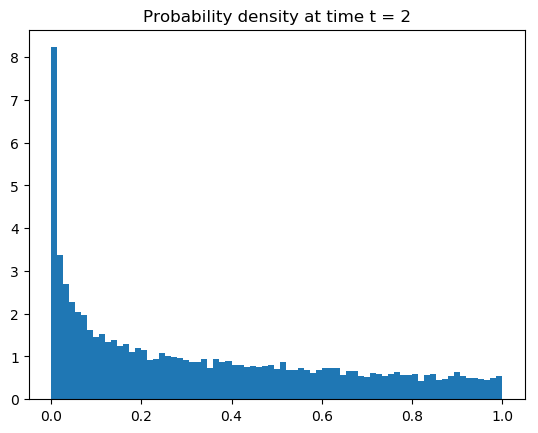

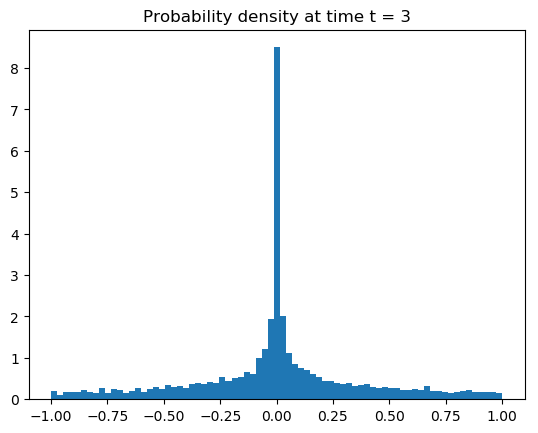

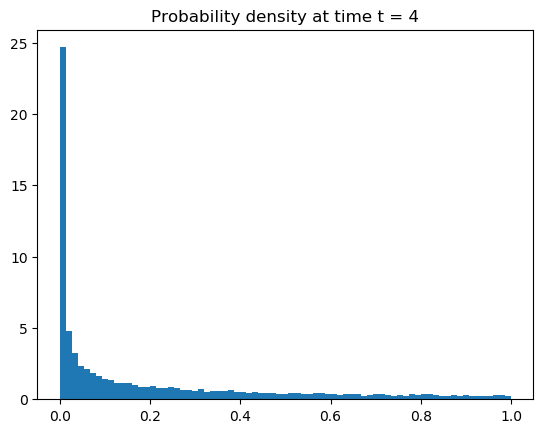

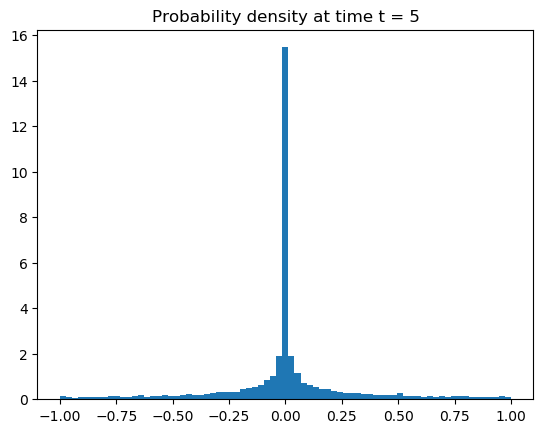

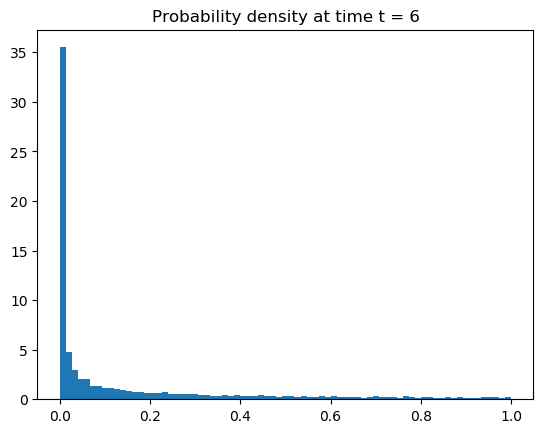

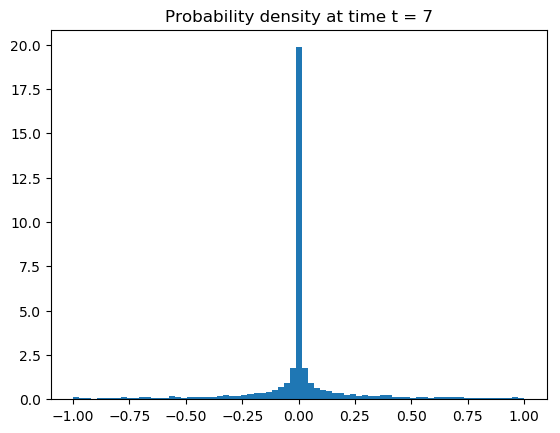

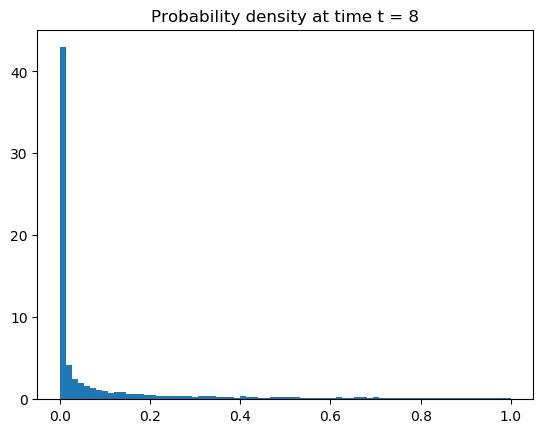

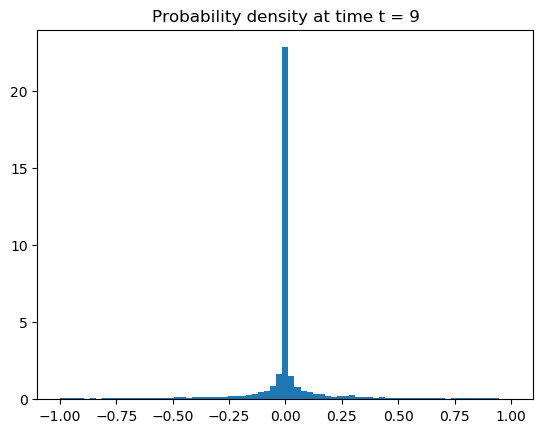

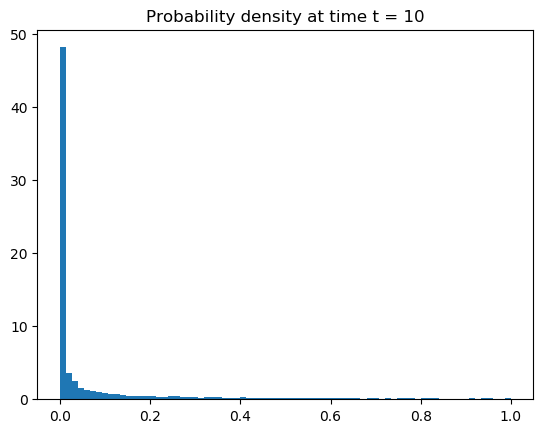

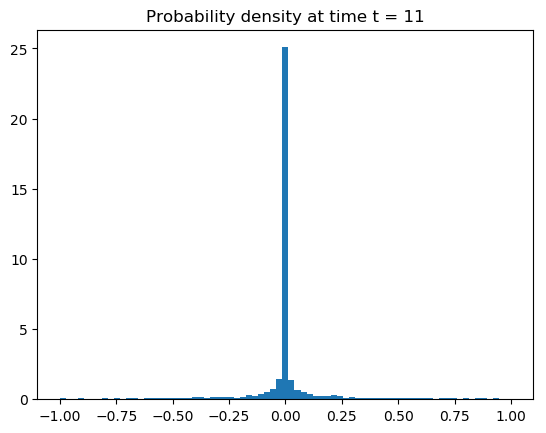

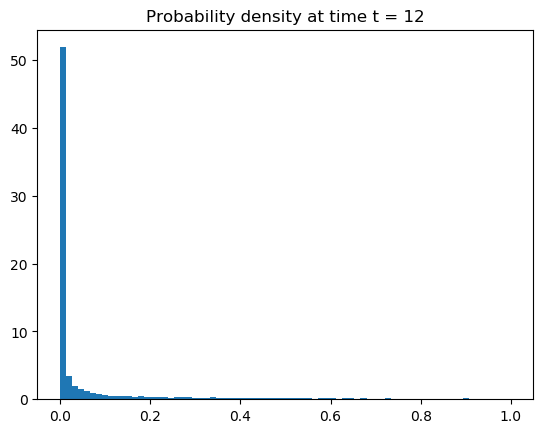

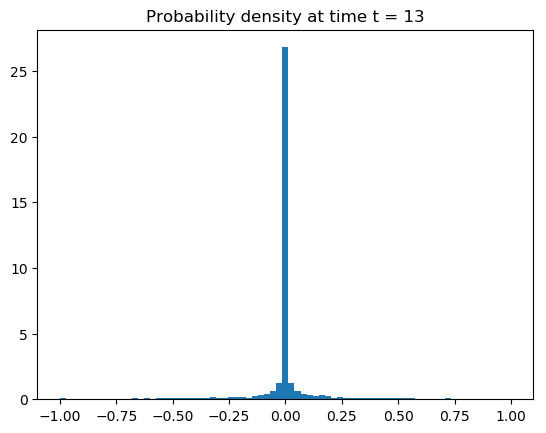

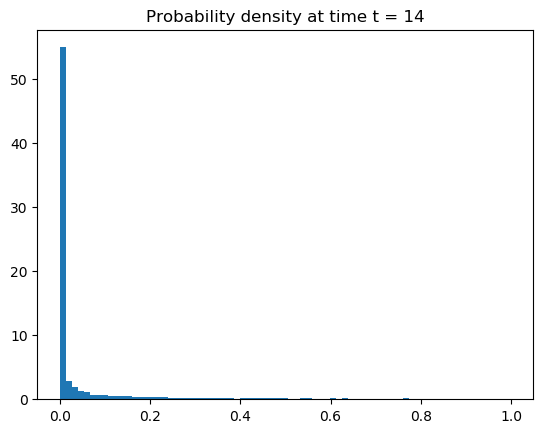

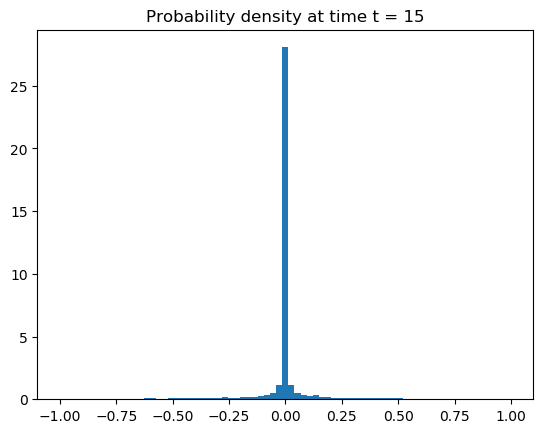

In [7]:
function data_to_plot(data, t)
	[ sample[t + 1] for sample in data ]
end

histogram_data = [ data_to_plot(x_samples, t) for t in 0:T ]

for t in 0:T
	figure(t+1)
	hist(histogram_data[t+1], density=true, bins=75)
	title("Probability density at time t = $t")
end